In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
import seaborn as sns
import ipyleaflet
from math import sin, cos, sqrt, atan2, radians
import folium
import folium.plugins as plugins
import os
from folium.plugins import MarkerCluster     # Map
from geographiclib.geodesic import Geodesic  # Map
import time, datetime                        # time data
import calendar
import scipy

%matplotlib inline

import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale
from sklearn.preprocessing import normalize
import statsmodels


/home/jk/enter/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("train.csv")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
test = pd.read_csv("test.csv")
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [4]:
train['log_duration'] = np.log1p(train['trip_duration'])
train.loc[:, 'log_duration'].tail()

1458639    6.658011
1458640    6.486161
1458641    6.639876
1458642    5.924256
1458643    5.293305
Name: log_duration, dtype: float64

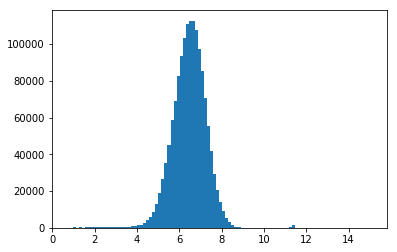

In [5]:
plt.hist(train['log_duration'].values, bins=100)
plt.show()

## Datetime type

In [6]:
train["pickup_datetime"] =  pd.to_datetime(train["pickup_datetime"])
test["pickup_datetime"] =  pd.to_datetime(test["pickup_datetime"])

In [7]:
#day of week
#date by month
train["pick_month"] = train["pickup_datetime"].dt.month.astype("int")
test["pick_month"] = test["pickup_datetime"].dt.month.astype("int")

#Monday=0, Sunday=6
train["pick_week"] = train["pickup_datetime"].dt.dayofweek.astype("int")
test["pick_week"] = test["pickup_datetime"].dt.dayofweek.astype("int")

#date
train['pick_date'] = train['pickup_datetime'].dt.date
test['pick_date'] = test['pickup_datetime'].dt.date

#date by hour
train["pick_hour"] = train["pickup_datetime"].dt.hour.astype("int")
test["pick_hour"] = test["pickup_datetime"].dt.hour.astype("int")

In [8]:
bins = [0, 8, 18, 24]
group_names = ["before work", "work", "after work"]
train['work_hour'] = pd.cut(train['pick_hour'], bins, labels=group_names, right=False)

test['work_hour'] = pd.cut(test['pick_hour'], bins, labels=group_names, right=False)

## Haversine Distance

In [9]:
from math import cos, asin, sqrt
def dist(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

In [10]:
# approximate radius of earth in km
# train
for i in range(len(train)):
    lat1 = train['pickup_latitude'][i]
    lon1 = train['pickup_longitude'][i]
    lat2 = train['dropoff_latitude'][i]
    lon2 = train['dropoff_longitude'][i]
    train.at[i, 'distance'] = dist(lat1, lon1, lat2, lon2)


In [11]:
# approximate radius of earth in km
# test
for i in range(len(test)):
    lat1 = test['pickup_latitude'][i]
    lon1 = test['pickup_longitude'][i]
    lat2 = test['dropoff_latitude'][i]
    lon2 = test['dropoff_longitude'][i]
    test.at[i, 'distance'] = dist(lat1, lon1, lat2, lon2)


## Manhattan Distance

In [12]:
train['manhattan_distance'] = (abs(train.dropoff_longitude - train.pickup_longitude) +
                            abs(train.dropoff_latitude - train.pickup_latitude))

In [13]:
test['manhattan_distance'] = (abs(test.dropoff_longitude - test.pickup_longitude) +
                            abs(test.dropoff_latitude - test.pickup_latitude))

## Direcrtion

In [14]:
def calculate_bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    '''Calculate the direction of travel in degrees'''
    pickup_lat_rads = np.radians(pickup_lat)
    pickup_long_rads = np.radians(pickup_long)
    dropoff_lat_rads = np.radians(dropoff_lat)
    dropoff_long_rads = np.radians(dropoff_long)
    long_delta_rads = np.radians(dropoff_long_rads - pickup_long_rads)
    
    y = np.sin(long_delta_rads) * np.cos(dropoff_lat_rads)
    x = (np.cos(pickup_lat_rads) * 
         np.sin(dropoff_lat_rads) - 
         np.sin(pickup_lat_rads) * 
         np.cos(dropoff_lat_rads) * 
         np.cos(long_delta_rads))
    
    return np.degrees(np.arctan2(y, x))

In [15]:
train['bearing'] = calculate_bearing(train.pickup_latitude,
                                     train.pickup_longitude,
                                     train.dropoff_latitude,
                                     train.dropoff_longitude)


In [16]:
test['bearing'] = calculate_bearing(test.pickup_latitude,
                                     test.pickup_longitude,
                                     test.dropoff_latitude,
                                     test.dropoff_longitude)

## Outlier

In [17]:
train.loc[train.distance > 200] = np.nan ##200km 넘는 데이터 제거
train.loc[train.trip_duration > 40000] = np.nan ##40000초(약 11시간)가 넘는 데이터 제거
train.loc[train.passenger_count == 0] = np.NAN   ### passenger 수가 0인 데이터 제거
train.dropna(inplace=True)

In [18]:
len(train)  ## outlier 2068개 제거

1456576

# Modeling

In [19]:
## train : dummy variable 만들기
dummy_workhour = pd.get_dummies(train['work_hour'],prefix='work_hour')
dummy_id = pd.get_dummies(train['vendor_id'],prefix='id')
dummy_snf = pd.get_dummies(train['store_and_fwd_flag'],prefix='snf')

In [20]:
## test : dummy variable 만들기
tdummy_workhour = pd.get_dummies(test['work_hour'],prefix='work_hour')
tdummy_id = pd.get_dummies(test['vendor_id'],prefix='id')
tdummy_snf = pd.get_dummies(test['store_and_fwd_flag'],prefix='snf')

In [21]:
dfX = pd.concat([dummy_workhour, dummy_id, dummy_snf, train[['distance', 'manhattan_distance', 
                                                             'passenger_count', 'bearing']]], axis=1)

In [22]:
dfX_test = pd.concat([tdummy_workhour, tdummy_id, tdummy_snf, test[['distance', 'manhattan_distance', 
                                                             'passenger_count', 'bearing']]], axis=1)

In [23]:
dfX.head()

,work_hour_before work,work_hour_work,work_hour_after work,id_1.0,id_2.0,snf_N,snf_Y,distance,manhattan_distance,passenger_count,bearing
0,0,1,0,0,1,1,0,1.498521,0.019859,1.0,174.333195
1,1,0,0,1,0,1,0,1.805507,0.026478,1.0,-178.051506
2,0,1,0,0,1,1,0,6.385098,0.080158,1.0,-179.629721
3,0,0,1,0,1,1,0,1.485498,0.015480,1.0,-179.872566
4,0,1,0,0,1,1,0,1.188588,0.010818,1.0,179.990812


In [24]:
### OLS
y = list(train['trip_duration'])
model = sm.OLS(y, dfX)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                 1.868e+05
Date:                Fri, 16 Mar 2018   Prob (F-statistic):               0.00
Time:                        15:23:21   Log-Likelihood:            -1.0993e+07
No. Observations:             1456576   AIC:                         2.199e+07
Df Residuals:                 1456565   BIC:                         2.199e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
work_hour_before work  -4.69e+

In [33]:
y_OLS = result.predict(dfX_test)
y_OLS = pd.DataFrame(y_OLS)
submission_test = pd.concat([test['id'], y_OLS], axis=1)
submission_test.to_csv('sub_OLS.csv')


In [25]:
### Decision Tree
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dfX, y, test_size=0.25)
from sklearn.tree import DecisionTreeRegressor

In [26]:
tree_1 = DecisionTreeRegressor(max_depth=9, random_state=1)
tree_1.fit(X_train, y_train)
print(tree_1.score(X_train, y_train))
print(tree_1.score(X_test, y_test))

0.6420438356316643
0.636641835408295


In [27]:
tree_2 = DecisionTreeRegressor(max_depth=11, random_state=1)
tree_2.fit(X_train, y_train)
print(tree_2.score(X_train, y_train))
print(tree_2.score(X_test, y_test))

0.6700096619573582
0.6177025582919502


In [28]:
tree_3 = DecisionTreeRegressor(max_depth=12, random_state=1)
tree_3.fit(X_train, y_train)
print(tree_3.score(X_train, y_train))
print(tree_3.score(X_test, y_test))

0.689579232638718
0.612485072657475


In [29]:
y_1 = tree_1.predict(dfX_test)
y_1 = pd.DataFrame(y_1)
submission_test = pd.concat([test['id'], y_1], axis=1)
submission_test.to_csv('sub_1.csv', sep=',', na_rep='NaN')
## RMSLE = 0.49705

In [30]:
y_2 = tree_2.predict(dfX_test)
y_2 = pd.DataFrame(y_2)
submission_test = pd.concat([test['id'], y_2], axis=1)
submission_test.to_csv('sub_2.csv', sep=',', na_rep='NaN')
## RMSLE = 0.49057

In [31]:
y_3 = tree_3.predict(dfX_test)
y_3 = pd.DataFrame(y_3)
submission_test = pd.concat([test['id'], y_3], axis=1)
submission_test.to_csv('sub_3.csv', sep=',', na_rep='NaN')
## RMSLE = 0.48919